In [1]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.6 MB/s eta 0:00:00


In [4]:
from qiskit.quantum_info import SparsePauliOp
from itertools import combinations
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from scipy.optimize import minimize
import numpy as np
import time
from numpy.linalg import eigvalsh
from qiskit.primitives import StatevectorEstimator as Estimator
estimator = Estimator()

def construct_hamiltonian(num_qubits, J, K, g, h):
    """Construct the Hamiltonian for a given number of qubits using provided coupling constants and fields."""
    terms = []

    # Add terms for Z-Z interactions
    for i, j in combinations(range(num_qubits), 2):
        zz_term = ['I'] * num_qubits  # Start with all identity
        zz_term[i] = 'Z'  # Set Z at qubit i
        zz_term[j] = 'Z'  # Set Z at qubit j
        terms.append((''.join(zz_term), J[i, j]))  # Z-Z interaction

    # Add terms for X-X interactions
    for i, j in combinations(range(num_qubits), 2):
        xx_term = ['I'] * num_qubits  # Start with all identity
        xx_term[i] = 'X'  # Set X at qubit i
        xx_term[j] = 'X'  # Set X at qubit j
        terms.append((''.join(xx_term), K[i, j]))  # X-X interaction

    # Add local fields for each qubit
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'  # Set X at qubit i
        terms.append((''.join(x_term), g[i]))  # X field on qubit i

        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'  # Set Z at qubit i
        terms.append((''.join(z_term), h))  # Z field on qubit i

    # Construct the Hamiltonian using SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(terms)
    return hamiltonian

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Estimate energy for a given Hamiltonian."""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost


def create_ansatz(num_qubits):
    """Create a parameterized ansatz circuit."""
    reference_circuit = QuantumCircuit(num_qubits)
    reference_circuit.x(0)  # Example initialization

    variational_form = TwoLocal(
        num_qubits,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)
    return ansatz

num_qubits = 8
num_repetitions = 1

for repetition in range(num_repetitions):
    # Generate random coupling constants and fields
    np.random.seed(repetition)
    J = np.random.uniform(low=-1, high=0, size=(num_qubits, num_qubits))
    for i in range(num_qubits):
        for j in range(num_qubits):
            if i >= j:
                J[i, j] = 0
    J = (J + J.T)

    np.random.seed(repetition + 10)
    K = np.random.uniform(low=-1, high=1, size=(num_qubits, num_qubits))
    for i in range(num_qubits):
        for j in range(num_qubits):
            if i >= j:
                K[i, j] = 0
    K = (K + K.T)

    np.random.seed(repetition + 20)
    h = np.random.uniform(low=-0.04, high=0.04)

    np.random.seed(repetition + 30)
    g = np.random.uniform(low=-6, high=6, size=num_qubits)

    # Construct the Hamiltonian
    hamiltonian = construct_hamiltonian(num_qubits, J, K, g, h)

    # Create the ansatz
    ansatz = create_ansatz(num_qubits)

    # Initial parameters for the ansatz
    x0 = np.ones(ansatz.num_parameters)

    # Minimize the energy using VQE
    start_time = time.time()
    result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})
    end_time = time.time()

    # Output results
    execution_time = end_time - start_time
    print(f"Minimum energy: {result.fun}")
    print(f"Optimal parameters: {result.x}")
    #print(f"Number of iterations: {result.nfev}")
    print(f"VQE runtime: {execution_time}")

    # Measure the run time for exact diagonalization
    start_time_exact = time.time()
    solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
    end_time_exact = time.time()
    exact_runtime = end_time_exact - start_time_exact

    print(f"Exact minimum eigenvalue: {solution_eigenvalue}")
    print(f"Exact diagonalization runtime: {exact_runtime:.4f} seconds")

    # Calculate and print the percent error
    percent_error = abs((result.fun - solution_eigenvalue) / solution_eigenvalue)
    print(f"Percent error: {percent_error:.2e}")


Minimum energy: -28.922801577931278
Optimal parameters: [ 3.05898702e-01  4.82152594e-01  9.77201571e-01  3.09221583e-01
  1.04371870e+00  1.78676666e+00  3.33496087e-01  1.17021098e+00
  1.48418704e+00  1.50502790e+00  1.58425089e+00  1.55853472e+00
  1.53523457e+00  1.55118702e+00  1.58346660e+00  1.67885392e+00
  3.14135758e+00  3.14151335e+00 -1.04464838e-03  3.14157801e+00
  6.70806020e-05  3.14139543e+00 -5.64310677e-04  3.14182031e+00
  2.96193238e-01 -2.68302302e-01  1.57233679e+00 -1.62278706e-01
  2.42746790e-01 -3.09643902e-01  2.11086425e+00 -3.30301929e-01]
VQE runtime: 13.625696897506714
Exact minimum eigenvalue: -29.191711311625596
Exact diagonalization runtime: 0.0346 seconds
Percent error: 9.21e-03


Minimum energy: -9.536921449732354
Optimal parameters: [ 1.71618262e+00  8.70311906e-01  1.95686865e+00  8.65621575e-01
  3.12945752e+00  3.14213844e+00 -1.73688462e-01  2.05223354e-04
  3.38818022e+00  3.02438187e+00  8.09435885e-01  2.33033671e+00
  1.57338676e+00  1.56382555e+00  1.55082824e+00  1.56395473e+00]
VQE runtime: 6.189172744750977
Exact minimum eigenvalue: -9.657838429768507
Exact diagonalization runtime: 0.0010 seconds
Percent error: 1.25e-02
Minimum energy: -14.18239079228204
Optimal parameters: [ 1.45712782e+00  3.98042041e-01  2.44479140e+00  5.99023095e-01
  1.06076410e+00 -1.78450792e-03  3.15251748e+00  3.24441090e+00
  1.87577379e+00  1.48828475e+00  1.31683111e+00  1.65749845e-01
  3.20237293e+00  2.17263032e-03  3.14049655e+00  1.54918106e+00
  1.57518868e+00  1.63048280e+00  3.42404499e-01 -6.71614663e-02]
VQE runtime: 8.374656200408936
Exact minimum eigenvalue: -14.38382122843429
Exact diagonalization runtime: 0.0005 seconds
Percent error: 1.40e-02
Minimum ene

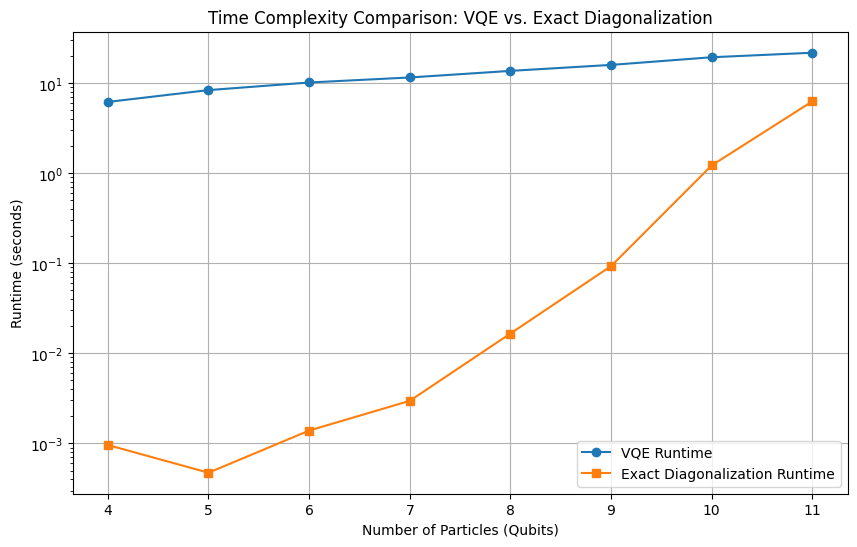

In [10]:
import matplotlib.pyplot as plt

# Define parameters
particle_counts = [4, 5, 6, 7, 8, 9, 10, 11]  # Number of particles to test
num_repetitions = 1

# Lists to store runtimes
vqe_runtimes = []
exact_runtimes = []

def construct_hamiltonian(num_qubits, J, K, g, h):
    """Construct the Hamiltonian for a given number of qubits using provided coupling constants and fields."""
    terms = []

    # Add terms for Z-Z interactions
    for i, j in combinations(range(num_qubits), 2):
        zz_term = ['I'] * num_qubits  # Start with all identity
        zz_term[i] = 'Z'  # Set Z at qubit i
        zz_term[j] = 'Z'  # Set Z at qubit j
        terms.append((''.join(zz_term), J[i, j]))  # Z-Z interaction

    # Add terms for X-X interactions
    for i, j in combinations(range(num_qubits), 2):
        xx_term = ['I'] * num_qubits  # Start with all identity
        xx_term[i] = 'X'  # Set X at qubit i
        xx_term[j] = 'X'  # Set X at qubit j
        terms.append((''.join(xx_term), K[i, j]))  # X-X interaction

    # Add local fields for each qubit
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'  # Set X at qubit i
        terms.append((''.join(x_term), g[i]))  # X field on qubit i

        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'  # Set Z at qubit i
        terms.append((''.join(z_term), h))  # Z field on qubit i

    # Construct the Hamiltonian using SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(terms)
    return hamiltonian

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Estimate energy for a given Hamiltonian."""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost


def create_ansatz(num_qubits):
    """Create a parameterized ansatz circuit."""
    reference_circuit = QuantumCircuit(num_qubits)
    reference_circuit.x(0)  # Example initialization

    variational_form = TwoLocal(
        num_qubits,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)
    return ansatz


for num_qubits in particle_counts:
    for repetition in range(num_repetitions):
        # Generate random coupling constants and fields
        np.random.seed(repetition)
        J = np.random.uniform(low=-1, high=0, size=(num_qubits, num_qubits))
        for i in range(num_qubits):
            for j in range(num_qubits):
                if i >= j:
                    J[i, j] = 0
        J = (J + J.T)

        np.random.seed(repetition + 10)
        K = np.random.uniform(low=-1, high=1, size=(num_qubits, num_qubits))
        for i in range(num_qubits):
            for j in range(num_qubits):
                if i >= j:
                    K[i, j] = 0
        K = (K + K.T)

        np.random.seed(repetition + 20)
        h = np.random.uniform(low=-0.04, high=0.04)

        np.random.seed(repetition + 30)
        g = np.random.uniform(low=-6, high=6, size=num_qubits)

        # Construct the Hamiltonian
        hamiltonian = construct_hamiltonian(num_qubits, J, K, g, h)

        # Create the ansatz
        ansatz = create_ansatz(num_qubits)

        # Initial parameters for the ansatz
        x0 = np.ones(ansatz.num_parameters)

        # VQE Runtime
        start_time = time.time()
        result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})
        end_time = time.time()
        vqe_runtime = end_time - start_time
        vqe_runtimes.append(vqe_runtime)
        # Output results
        print(f"Minimum energy: {result.fun}")
        print(f"Optimal parameters: {result.x}")
        #print(f"Number of iterations: {result.nfev}")
        print(f"VQE runtime: {vqe_runtime}")

        # Exact Diagonalization Runtime
        start_time_exact = time.time()
        solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
        end_time_exact = time.time()
        exact_runtime = end_time_exact - start_time_exact
        exact_runtimes.append(exact_runtime)
        print(f"Exact minimum eigenvalue: {solution_eigenvalue}")
        print(f"Exact diagonalization runtime: {exact_runtime:.4f} seconds")

        # Calculate and print the percent error
        percent_error = abs((result.fun - solution_eigenvalue) / solution_eigenvalue)
        print(f"Percent error: {percent_error:.2e}")
        print("=======================================================================")


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(particle_counts, vqe_runtimes, label="VQE Runtime", marker='o')
plt.plot(particle_counts, exact_runtimes, label="Exact Diagonalization Runtime", marker='s')
plt.xlabel("Number of Particles (Qubits)")
plt.ylabel("Runtime (seconds)")
plt.title("Time Complexity Comparison: VQE vs. Exact Diagonalization")
plt.yscale("log")  # Log scale for better visibility if differences are large
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pip install  qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.3 MB/s eta 0:00:00


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="db12955afa2f72276949f362bb0f5166a12cbd149bf2cde3515a299d42d7367b88eb859ab8d86ca5382cb4d1c83eb65ee509d3b09afb726d7ab2ba389050d91f", overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [ ]:
backend = service.least_busy(operational=True, simulator=False)
print("The Backend is: ", backend.name)


The Backend is:  ibm_brisbane


In [ ]:
from qiskit.primitives import StatevectorEstimator

# Initialize Qiskit Runtime Service
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print("The Backend is: ", backend.name)

def construct_hamiltonian(num_qubits, J_ij=1.0, K_ij=0.5, g_i=0.8, h=0.6):
    """Construct the Hamiltonian for a given number of qubits."""
    terms = []

    # Add terms for Z-Z interactions
    for i, j in combinations(range(num_qubits), 2):
        zz_term = ['I'] * num_qubits
        zz_term[i] = 'Z'
        zz_term[j] = 'Z'
        terms.append((''.join(zz_term), J_ij))

    # Add terms for X-X interactions
    for i, j in combinations(range(num_qubits), 2):
        xx_term = ['I'] * num_qubits
        xx_term[i] = 'X'
        xx_term[j] = 'X'
        terms.append((''.join(xx_term), K_ij))

    # Add local fields for each qubit
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'
        terms.append((''.join(x_term), g_i))

        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'
        terms.append((''.join(z_term), h))

    # Construct the Hamiltonian using SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(terms)
    return hamiltonian

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Estimate energy for a given Hamiltonian."""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

def create_ansatz(num_qubits):
    """Create a parameterized ansatz circuit."""
    reference_circuit = QuantumCircuit(num_qubits)
    reference_circuit.x(0)  # Example initialization

    variational_form = TwoLocal(
        num_qubits,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)
    return ansatz

num_qubits = 6
hamiltonian = construct_hamiltonian(num_qubits)
ansatz = create_ansatz(num_qubits)

# Initial parameters for the ansatz
x0 = np.ones(ansatz.num_parameters)

# Instantiate the StatevectorEstimator with the selected backend
from qiskit.primitives import StatevectorEstimator as Estimator
estimator = Estimator(backend=backend)
#estimator = StatevectorEstimator(backend=backend)

# Minimize the energy
start_time = time.time()
result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})
end_time = time.time()

# Output results
execution_time = end_time - start_time
print(f"Minimum energy: {result.fun}")
print(f"Optimal parameters: {result.x}")
print(f"Number of iterations: {result.nfev}")
print(f"VQE runtime: {execution_time:.4f} seconds")

# Exact minimum eigenvalue calculation
from numpy.linalg import eigvalsh

# Measure the run time for exact diagonalization
start_time_exact = time.time()
solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
end_time_exact = time.time()
exact_runtime = end_time_exact - start_time_exact

print(f"Exact minimum eigenvalue: {solution_eigenvalue}")
print(f"Exact diagonalization runtime: {exact_runtime:.4f} seconds")

# Calculate and print the percent error
percent_error = abs((result.fun - solution_eigenvalue) / solution_eigenvalue)
print(f"Percent error: {percent_error:.2e}")

The Backend is:  ibm_brisbane


TypeError: StatevectorEstimator.__init__() got an unexpected keyword argument 'backend'

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimatorV2
from scipy.optimize import minimize
from itertools import combinations
import time


print("The Backend is: ", backend.name)

def construct_hamiltonian(num_qubits, J_ij=1.0, K_ij=0.5, g_i=0.8, h=0.6):
    """Construct the Hamiltonian for a given number of qubits."""
    terms = []

    # Add terms for Z-Z interactions
    for i, j in combinations(range(num_qubits), 2):
        zz_term = ['I'] * num_qubits
        zz_term[i] = 'Z'
        zz_term[j] = 'Z'
        terms.append((''.join(zz_term), J_ij))

    # Add terms for X-X interactions
    for i, j in combinations(range(num_qubits), 2):
        xx_term = ['I'] * num_qubits
        xx_term[i] = 'X'
        xx_term[j] = 'X'
        terms.append((''.join(xx_term), K_ij))

    # Add local fields for each qubit
    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'
        terms.append((''.join(x_term), g_i))

        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'
        terms.append((''.join(z_term), h))

    # Construct the Hamiltonian using SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(terms)
    return hamiltonian

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Estimate energy for a given Hamiltonian."""
    pub = (ansatz, hamiltonian, params)
    result = estimator.run([pub]).result()
    cost = result.evs[0]  # Access the energy value directly from the result
    return cost

def create_ansatz(num_qubits):
    """Create a parameterized ansatz circuit."""
    reference_circuit = QuantumCircuit(num_qubits)
    reference_circuit.x(0)  # Example initialization

    variational_form = TwoLocal(
        num_qubits,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks="cx",
        entanglement="linear",
        reps=1,
    )
    ansatz = reference_circuit.compose(variational_form)
    return ansatz

num_qubits = 6
hamiltonian = construct_hamiltonian(num_qubits)
ansatz = create_ansatz(num_qubits)

# Initial parameters for the ansatz
x0 = np.ones(ansatz.num_parameters)

# Instantiate the BackendEstimatorV2
estimator = BackendEstimatorV2(backend)

# Minimize the energy
start_time = time.time()
result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})
end_time = time.time()

# Output results
execution_time = end_time - start_time
print(f"Minimum energy: {result.fun}")
print(f"Optimal parameters: {result.x}")
print(f"Number of iterations: {result.nfev}")
print(f"VQE runtime: {execution_time:.4f} seconds")

# Exact minimum eigenvalue calculation
from numpy.linalg import eigvalsh

# Measure the run time for exact diagonalization
start_time_exact = time.time()
solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
end_time_exact = time.time()
exact_runtime = end_time_exact - start_time_exact

print(f"Exact minimum eigenvalue: {solution_eigenvalue}")
print(f"Exact diagonalization runtime: {exact_runtime:.4f} seconds")

# Calculate and print the percent error
percent_error = abs((result.fun - solution_eigenvalue) / solution_eigenvalue)
print(f"Percent error: {percent_error:.2e}")


The Backend is:  ibm_brisbane


TypeError: BackendEstimatorV2.__init__() takes 1 positional argument but 2 were given

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator
from itertools import combinations
from qiskit.circuit.library import TwoLocal
from numpy.linalg import eigvalsh

# Estimator for calculating expectation values
estimator = Estimator()

def create_hamiltonian_ansatz(num_qubits, J, K, g, h):
    """Creates a parameterized quantum circuit for simulating the Hamiltonian."""
    circuit = QuantumCircuit(num_qubits)

    # Define parameters for variational angles
    theta_params = [Parameter(f'theta_{i}') for i in range(num_qubits)]

    # Apply parameterized single-qubit rotations
    for i in range(num_qubits):
        circuit.rx(theta_params[i], i)

    # Add parameterized Z-Z interactions
    for i, j in combinations(range(num_qubits), 2):
        zz_param = Parameter(f'zz_{i}_{j}')
        circuit.rzz(zz_param, i, j)

    # Add parameterized X-X interactions
    for i, j in combinations(range(num_qubits), 2):
        xx_param = Parameter(f'xx_{i}_{j}')
        circuit.rxx(xx_param, i, j)

    # Apply additional local fields
    for i in range(num_qubits):
        g_param = Parameter(f'g_{i}')
        circuit.rx(g_param, i)

        h_param = Parameter(f'h_{i}')
        circuit.rz(h_param, i)

    return circuit

def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Estimates energy for a given parameterized circuit and Hamiltonian."""
    bound_circuit = circuit.assign_parameters(params)
    pub = (bound_circuit, hamiltonian)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

def construct_hamiltonian(num_qubits, J, K, g, h):
    """Construct the Hamiltonian for a given number of qubits."""
    terms = []
    for i, j in combinations(range(num_qubits), 2):
        zz_term = ['I'] * num_qubits
        zz_term[i] = 'Z'
        zz_term[j] = 'Z'
        terms.append((''.join(zz_term), J[i, j]))

        xx_term = ['I'] * num_qubits
        xx_term[i] = 'X'
        xx_term[j] = 'X'
        terms.append((''.join(xx_term), K[i, j]))

    for i in range(num_qubits):
        x_term = ['I'] * num_qubits
        x_term[i] = 'X'
        terms.append((''.join(x_term), g[i]))

        z_term = ['I'] * num_qubits
        z_term[i] = 'Z'
        terms.append((''.join(z_term), h))

    return SparsePauliOp.from_list(terms)

num_qubits = 4
J = np.random.uniform(-1, 0, size=(num_qubits, num_qubits))
K = np.random.uniform(-1, 1, size=(num_qubits, num_qubits))
g = np.random.uniform(-0.6, 0.6, size=num_qubits)
h = np.random.uniform(-0.04, 0.04)

# Create Hamiltonian
hamiltonian = construct_hamiltonian(num_qubits, J, K, g, h)

# Create ansatz circuit
ansatz = create_hamiltonian_ansatz(num_qubits, J, K, g, h)

# Initial parameters for the ansatz
x0 = np.random.random(len(ansatz.parameters))

# Run the optimization
start_time = time.time()
result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method='COBYLA', options={'maxiter': 1000, 'disp': True})
end_time = time.time()

execution_time = end_time - start_time
print(f"Minimum energy: {result.fun}")
print(f"Optimal parameters: {result.x}")
print(f"VQE runtime: {execution_time:.4f} seconds")

# Measure the run time for exact diagonalization
start_time_exact = time.time()
solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
end_time_exact = time.time()
exact_runtime = end_time_exact - start_time_exact

print(f"Exact minimum eigenvalue: {solution_eigenvalue}")
print(f"Exact diagonalization runtime: {exact_runtime:.4f} seconds")

# Calculate and print the percent error
percent_error = abs((result.fun - solution_eigenvalue) / solution_eigenvalue)
print(f"Percent error: {percent_error:.2e}")

Minimum energy: -2.8242739869943914
Optimal parameters: [ 0.07606273 -0.00571669  0.99488195 -0.1309452   0.72630346  0.95237176
  1.774253    0.82860752 -0.29510308 -0.19214994  0.58708298 -0.41120602
  0.39366201  0.15864151  0.52310262  0.10377816  0.24743059  0.23730342
  0.22734932  0.92619754  0.13690148  1.21145026 -0.00245761  1.18703091]
VQE runtime: 6.7044 seconds
Exact minimum eigenvalue: -3.0922032960927845
Exact diagonalization runtime: 0.0150 seconds
Percent error: 8.66e-02
